In [ ]:
!pip install -U spacy

     |████████████████████████████████| 12.8MB 239kB/s 
     |████████████████████████████████| 9.1MB 38.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 460kB 48.8MB/s 
     |████████████████████████████████| 1.1MB 47.5MB/s 
     |████████████████████████████████| 122kB 54.2MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=696e726ab73013216301ff2ed77410e2ebbe54b554ce3e3b27be4912e848648f
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: smart-open 5.0.0
    Uninstalling smart-open-5.0.0:
      Successfully uninstalled smart-open-5.0.0
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-

In [ ]:
!python -m spacy download ru_core_news_sm

2021-05-30 14:21:26.794800: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 17.9MB 1.2MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 8.2MB 11.6MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
!git clone https://github.com/feralvam/easse.git && cd easse && pip install .

Cloning into 'easse'...
remote: Enumerating objects: 1888, done.
remote: Counting objects: 100% (455/455), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 1888 (delta 260), reused 312 (delta 167), pack-reused 1433
Receiving objects: 100% (1888/1888), 33.78 MiB | 21.59 MiB/s, done.
Resolving deltas: 100% (1133/1133), done.
Processing /content/easse
     |████████████████████████████████| 1.5MB 7.5MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 901kB 26.2MB/s 
     |████████████████████████████████| 163kB 34.0MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git to /tmp/pip-install-ktw8fzwq/tseval
  Running command git clone -q https://github.com/facebookresearch/text-simplification-evaluation.git /tmp/pip-install-ktw8fzwq/tseval
  Cloning https://github.com/cisnlp/simalign.git to /tmp/pip-install-ktw8fzwq/simalign
  Running com

In [ ]:
from string import punctuation
punkt = punctuation + "''«»"

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from torchtext.data.metrics import bleu_score
from easse.sari import corpus_sari

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
spacy_ru = spacy.load("ru_core_news_sm")

In [ ]:
def tokenize_ru1(text):
    """
    Tokenizes Russian text from a string into a list of strings (tokens) and reverses it
    """
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'<.*?>',' ', text)
    text = re.sub(r'\d+',' ', text)
    text = re.sub(r'#\w+',' ', text)
    text = re.sub(r'@\w+',' ', text)

    return [tok.text for tok in spacy_ru.tokenizer(text) if tok.text != " " and tok.text != ""\
              and tok.text.strip() not in punkt] #[::-1]

In [ ]:
def tokenize_ru2(text):
    """
    Tokenizes Russian text from a string into a list of strings (tokens)
    """
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'<.*?>',' ', text)
    text = re.sub(r'\d+',' ', text)
    text = re.sub(r'#\w+',' ', text)
    text = re.sub(r'@\w+',' ', text)

    return [tok.text for tok in spacy_ru.tokenizer(text) if tok.text != " " and tok.text != ""\
              and tok.text.strip() not in punkt]

In [ ]:
SRC = Field(sequential = True, 
            use_vocab = True, 
            tokenize = tokenize_ru1, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(sequential = True, 
            use_vocab = True,
            tokenize = tokenize_ru2, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

In [ ]:
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}

In [ ]:
train_data, valid_data, test_data = TabularDataset.splits(
                                                          path = '/content/drive/MyDrive/datasets/diplom',
                                                          train = 'train_n.csv',
                                                          validation = 'valid_n.csv',
                                                          test = 'test_n.csv',
                                                          format = 'csv',
                                                          fields = fields)

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 124172
Number of validation examples: 15521
Number of testing examples: 15522


In [ ]:
print(vars(train_data.examples[10]))

{'src': ['сарабанда', 'вдохновила', 'название', 'последнего', 'фильма', 'ингмара', 'бергмана', 'сарабанда'], 'trg': ['сарабанда', 'много', 'использовалась', 'в', 'фильмах', 'в', 'том', 'числе', 'в', 'фильме', 'ингмара', 'бергмана', 'сарабанда']}


In [ ]:
SRC.build_vocab(train_data, min_freq = 5)
TRG.build_vocab(train_data, min_freq = 5)

In [ ]:
print(f"Unique tokens in source vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target vocabulary: {len(TRG.vocab)}")

Unique tokens in source vocabulary: 43376
Unique tokens in target vocabulary: 36163


In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
                
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        

        embedded = self.dropout(tok_embedded + pos_embedded)
                
        conv_input = self.emb2hid(embedded)
        
        conv_input = conv_input.permute(0, 2, 1) 
        
        for i, conv in enumerate(self.convs):
        
            conved = conv(self.dropout(conv_input))

            conved = F.glu(conved, dim = 1)

            conved = (conved + conv_input) * self.scale
            
            conv_input = conved
        
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        combined = (conved + embedded) * self.scale
                
        return conved, combined

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
                
        combined = (conved_emb + embedded) * self.scale
                        
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
                
        attention = F.softmax(energy, dim=2)
                    
        attended_encoding = torch.matmul(attention, encoder_combined)
                
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
                
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
                        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        embedded = self.dropout(tok_embedded + pos_embedded)
                
        conv_input = self.emb2hid(embedded)
                
        conv_input = conv_input.permute(0, 2, 1) 
                
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            conv_input = self.dropout(conv_input)
        
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
                
            conved = conv(padded_conv_input)
            
            conved = F.glu(conved, dim = 1)
            
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
                        
            conved = (conved + conv_input) * self.scale
                        
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
                     
        output = self.fc_out(self.dropout(conved))
                    
        return output, attention

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        encoder_conved, encoder_combined = self.encoder(src)
          
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 
ENC_LAYERS = 10 
DEC_LAYERS = 10 
ENC_KERNEL_SIZE = 3 
DEC_KERNEL_SIZE = 3 
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 61,973,571 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
             
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def save_checkpoint(model, optimizer, save_path, epoch, train_loss, valid_loss, best_valid_loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), #добавить train и valid loss
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'best_valid_loss': best_valid_loss,
        'epoch': epoch+1
    }, save_path)

In [ ]:
def load_checkpoint(load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    valid_loss = checkpoint['valid_loss']
    best_valid_loss = checkpoint['best_valid_loss']

    
    return model, optimizer, epoch, train_loss, valid_loss, best_valid_loss

In [ ]:
model, optimizer, epoch_n, train_loss, valid_loss, best_valid_loss  = load_checkpoint('/content/drive/MyDrive/datasets/diplom/checkpoints/checkpoint51.pth')

In [ ]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/datasets/diplom/models/tut51-model.pt') #первая с обратным порядком была tut5-model.pt

    save_checkpoint(model, optimizer, '/content/drive/MyDrive/datasets/diplom/checkpoints/checkpoint51.pth', epoch, train_loss, valid_loss, best_valid_loss) #5

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 41s
	Train Loss: 5.917 | Train PPL: 371.253
	 Val. Loss: 4.319 |  Val. PPL:  75.084
Epoch: 02 | Time: 5m 44s
	Train Loss: 4.437 | Train PPL:  84.544
	 Val. Loss: 3.749 |  Val. PPL:  42.481
Epoch: 03 | Time: 5m 43s
	Train Loss: 3.929 | Train PPL:  50.857
	 Val. Loss: 3.535 |  Val. PPL:  34.309
Epoch: 04 | Time: 5m 44s
	Train Loss: 3.633 | Train PPL:  37.834
	 Val. Loss: 3.416 |  Val. PPL:  30.462
Epoch: 05 | Time: 5m 44s
	Train Loss: 6.636 | Train PPL: 762.366
	 Val. Loss: 4.312 |  Val. PPL:  74.590
Epoch: 06 | Time: 5m 44s
	Train Loss: 4.125 | Train PPL:  61.880
	 Val. Loss: 3.325 |  Val. PPL:  27.806
Epoch: 07 | Time: 5m 43s
	Train Loss: 3.158 | Train PPL:  23.529
	 Val. Loss: 3.200 |  Val. PPL:  24.524
Epoch: 08 | Time: 5m 43s
	Train Loss: 2.996 | Train PPL:  20.011
	 Val. Loss: 3.146 |  Val. PPL:  23.244
Epoch: 09 | Time: 5m 43s
	Train Loss: 2.863 | Train PPL:  17.508
	 Val. Loss: 3.080 |  Val. PPL:  21.767
Epoch: 10 | Time: 5m 43s
	Train Loss: 2.753 | Train PPL

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/diplom/models/tut51-model.pt')) #5

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.061 | Test PPL:  21.345 |


### BLEU and EASSE

In [ ]:
def simplify_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('ru_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:-1]

In [ ]:
def simplify_sentence2(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['p.', 'crysan', 'p.', 'sorbilis', 'это', 'вьющееся', 'растение', 'из', 'семейства', 'кленовых', 'sapindaceae', 'произрастающих', 'в', 'бассейне', 'амазонки', 'и', 'особенно', 'распространенных', 'в', 'бразилии']
trg = ['p.', 'crysan', 'p.', 'sorbilis', 'кустарник', 'или', 'небольшое', 'деревце', 'из', 'семейства', 'sapindaceae']


In [ ]:
translation, attention = simplify_sentence2(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['p.', '<unk>', 'p.', '<unk>', 'это', 'растение', 'из', 'семейства', '<unk>', '<unk>', 'произрастающих', 'в', 'бассейне', 'амазонки', 'и', 'особенно', 'распространенных', 'в', 'бразилии', '<eos>']


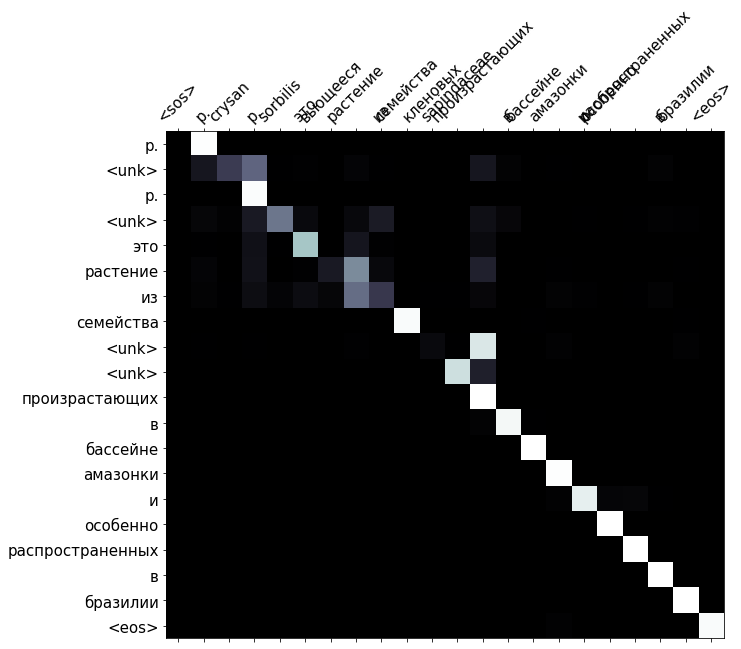

In [ ]:
display_attention(src, translation, attention)

In [ ]:
for i in range(1000):
  src = vars(train_data.examples[i])['src']
  trg = vars(train_data.examples[i])['trg']
  print(f'src = {src}')
  print(f'trg = {trg}')
  simple = simplify_sentence(src, SRC, TRG, model, device, max_len=50)
  print(f'simple = {simple}')
  print(i)
  print()

Выходные данные были обрезаны до нескольких последних строк (5000).
src = ['шоу', 'закончилось', 'в', 'году', 'но', 'в', 'конце', 'года', 'тимберлейк', 'пригласил', 'чейза', 'в', 'мужскую', 'певческую', 'группу', 'организованную', 'менеджером', 'бойз', 'бэнда', 'лу', 'перлманом', 'которая', 'в', 'конечном', 'итоге', 'стала', 'n', 'sync']
trg = ['когда', 'шоу', 'закончилось', 'в', 'году', 'тимберлейк', 'вместе', 'с', 'чейзом', 'и', 'другими', 'сформировал', 'мужскую', 'певческую', 'группу', 'nsync']
simple = ['шоу', 'закончилось', 'в', 'году', 'но', 'в', 'конце', 'года', 'тимберлейк', 'пригласил', '<unk>', 'в', 'мужскую', '<unk>', 'группу', '<unk>', 'менеджером', 'бойз', 'бэнда', 'лу', '<unk>']
0

src = ['эммануэль', 'олисадебе', 'родился', 'декабря', 'года', 'в', 'варри', 'польский', 'нападающий', 'нигерийского', 'происхождения', 'последний', 'раз', 'играл', 'за', 'китайский', 'футбольный', 'клуб', 'henan', 'construction', 'в', 'китайской', 'суперлиге']
trg = ['эммануэль', 'олисадебе',

In [ ]:
for i in range(2000):
  src = vars(valid_data.examples[i])['src']
  trg = vars(valid_data.examples[i])['trg']
  print(f'src = {src}')
  print(f'trg = {trg}')
  simple = simplify_sentence(src, SRC, TRG, model, device, max_len=50)
  print(f'simple = {simple}')
  print()

Выходные данные были обрезаны до нескольких последних строк (5000).
src = ['женщин', 'права', 'за', 'движение', 'общественное', 'женское', 'иранское', 'себя', 'в', 'включает', 'движение', 'женское', 'иранское']
trg = ['иранское', 'женское', 'движение', 'также', 'называемое', 'персидским', 'женским', 'движением', 'включает', 'иранское', 'женское', 'общественное', 'движение', 'за', 'права', 'женщин']
simple = ['<unk>', 'женское', 'движение', 'включает', 'в', 'себя', '<unk>', 'женское', 'общественное', 'движение', 'за', 'права', 'женщин']

src = ['тягу', 'реактивную', 'использует', 'который', 'гипонома', 'своего', 'помощью', 'с', 'нее', 'из', 'и', 'камеру', 'жилую', 'в', 'воду', 'втягивает', 'наутилус', 'плавать', 'чтобы']
trg = ['чтобы', 'плавать', 'наутилус', 'втягивает', 'воду', 'в', 'жилую', 'камеру', 'и', 'из', 'нее', 'и', 'использует', 'реактивный', 'двигатель']
simple = ['чтобы', 'плавать', '<unk>', 'воду', 'в', '<unk>', 'камеру', 'и', 'из', 'нее', 'с', 'помощью', 'своего', '<unk>'

In [ ]:
for i in range(2000):
  src = vars(test_data.examples[i])['src']
  trg = vars(test_data.examples[i])['trg']
  print(f'src = {src[::-1]}')
  print(f'trg = {trg}')
  simple = simplify_sentence(src, SRC, TRG, model, device, max_len=50)
  print(f'simple = {simple}')
  print()

Выходные данные были обрезаны до нескольких последних строк (5000).
src = ['когда', 'страница', 'перемещается', 'переименовывается', 'отображается', 'вся', 'история', 'редактирования', 'статьи', 'до', 'и', 'после', 'перемещения']
trg = ['когда', 'страница', 'перемещается', 'переименовывается', 'отображается', 'вся', 'история', 'статьи', 'до', 'и', 'после', 'перемещения']
simple = ['когда', 'страница', 'перемещается', '<unk>', 'отображается', 'вся', 'история', 'редактирования', 'статьи', 'до', 'и', 'после', 'перемещения']

src = ['бэнкстон', 'город', 'в', 'округе', 'дабьюк', 'штат', 'айова', 'сша']
trg = ['бэнкстон', 'город', 'в', 'штате', 'айова', 'в', 'сша']
simple = ['<unk>', 'город', 'в', 'штате', 'айова', 'в', 'сша']

src = ['в', 'информатике', 'линейный', 'поиск', 'или', 'последовательный', 'поиск', 'это', 'метод', 'поиска', 'определенного', 'значения', 'в', 'списке', 'который', 'состоит', 'из', 'проверки', 'каждого', 'из', 'его', 'элементов', 'по', 'одному', 'и', 'последовательно

In [ ]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg = simplify_sentence(src, src_field, trg_field, model, device, max_len=50)
        
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score =  calculate_bleu(test_data, SRC, TRG, model, device, max_len = 50)

In [ ]:
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.67


28.96

29.12

In [ ]:
def calculate_bleu2(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    bleus = []
    srcs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg = simplify_sentence(src, src_field, trg_field, model, device, max_len=50)
        
        pred_trg = pred_trg[:-1]

        bl = bleu_score([trg], [[pred_trg]])
        
        pred_trgs.append([pred_trg])
        trgs.append([trg])
        bleus.append(bl)
        srcs.append([src[::-1]])
        
        
    return pred_trgs, trgs, bleus, srcs

In [ ]:
pred_trgs, trgs, bleus, srcs = calculate_bleu2(test_data, SRC, TRG, model, device, max_len = 50)

In [ ]:
ix = [i for i in range(15522)]

In [ ]:
dict = {'src': srcs, 'trg': trgs, 'smpl': pred_trgs, 'score': bleus, 'ix': ix} 

In [ ]:
df = pd.DataFrame(dict)

In [ ]:
df

,src,trg,smpl,score,ix
0,"[[книга, претендует, на, то, чтобы, быть, наст...","[[говорят, что, эта, книга, настоящий, дневник...","[[книга, претендует, на, то, чтобы, быть, наст...",0.000000,0
1,"[[точно, так, же, зонтичная, организация, это,...","[[точно, так, же, зонтичная, группа, может, бы...","[[точно, так, же, <unk>, организация, это, цен...",0.179233,1
2,"[[это, совместная, резиденция, епархии, тарб, ...","[[это, совместная, резиденция, епархии, тарб, ...","[[это, совместная, резиденция, епархии, <unk>,...",0.058833,2
3,"[[курсель, ла, фор, êt, это, коммуна, в, депар...","[[он, находится, в, регионе, пэи, де, ла, луар...","[[он, находится, в, регионе, пэи, де, ла, луар...",0.919323,3
4,"[[гестрикланд, самая, южная, из, провинций, но...","[[провинция, является, самым, южным, районом, ...","[[<unk>, самая, южная, из, провинций]]",0.000000,4
...,...,...,...,...,...
15517,"[[скайлайн, город, в, округе, голубая, земля, ...","[[скайлайн, город, в, округе, голубая, земля, ...","[[<unk>, город, в, штате, миннесота, в]]",0.000000,15517
15518,"[[караббия, район, города, лугано, швейцария]]","[[караббия, это, муниципалитет, района, лугано...","[[<unk>, район, города, лугано]]",0.000000,15518
15519,"[[главный, госпиталь, был, создан, мужем, и, ж...","[[сериал, создали, сценаристы, мыла, фрэнк, и,...","[[главный, госпиталь, был, создан, мужем, и, ж...",0.000000,15519
15520,"[[в, начале, октября, в, западной, части, атла...","[[ранним, утром, октября, национальный, центр,...","[[в, начале, октября, в, западной, части, атла...",0.000000,15520


In [ ]:
df = df.sort_values(by=['score'])

In [ ]:
df['score'].value_counts()

0.000000    7464
0.614788      97
0.930605      96
0.893154      88
0.912168      82
            ... 
0.430734       1
0.146427       1
0.228984       1
0.140666       1
0.103840       1
Name: score, Length: 4491, dtype: int64

In [ ]:
df.tail(20)

,src,trg,smpl,score,ix
14235,"[[вестрехем, это, коммуна, в, департаменте, па...","[[он, находится, в, регионе, нор, па, де, кале...","[[он, находится, в, регионе, нор, па, де, кале...",0.930605,14235
10307,"[[в, европе, есть, несколько, деревень, для, п...","[[в, европе, есть, несколько, деревень, для, п...","[[в, европе, есть, несколько, деревень, для, п...",0.931063,10307
1788,"[[когда, испанские, поселенцы, взяли, под, сво...","[[когда, испанские, поселенцы, взяли, под, сво...","[[когда, испанские, поселенцы, взяли, под, сво...",0.935133,1788
1159,"[[трасса, названа, в, честь, покойного, основа...","[[трасса, названа, в, честь, покойного, основа...","[[трасса, названа, в, честь, покойного, основа...",0.935133,1159
1348,"[[шторм, принес, сильный, снегопад, на, северо...","[[шторм, принес, сильный, снегопад, на, северо...","[[шторм, принес, сильный, снегопад, на, северо...",0.935133,1348
1492,"[[в, апреле, года, фей, и, ричмонд, купили, кв...","[[в, апреле, года, фей, и, ричмонд, купили, кв...","[[в, апреле, года, фей, и, ричмонд, купили, кв...",0.939104,1492
8822,"[[цель, заключалась, в, том, чтобы, сделать, п...","[[цель, заключалась, в, том, чтобы, сделать, п...","[[цель, заключалась, в, том, чтобы, сделать, п...",0.939104,8822
8021,"[[такси, американский, ситком, который, трансл...","[[такси, американский, ситком, который, трансл...","[[такси, американский, ситком, который, трансл...",0.939104,8021
7427,"[[более, лет, википедия, представляет, собой, ...","[[более, лет, википедия, представляет, собой, ...","[[более, лет, википедия, представляет, собой, ...",0.942615,7427
13200,"[[пустыня, долины, инда, занимает, площадь, в,...","[[пустыня, долины, инда, занимает, площадь, в,...","[[пустыня, долины, инда, занимает, площадь, в,...",0.945742,13200


In [ ]:
df.to_csv('/content/drive/MyDrive/datasets/diplom/conv_cleu_scores.csv')

### SARI

In [ ]:
def calculate_sari(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    origs = []

    for datum in data:
      src = vars(datum)['src']
      trg = vars(datum)['trg']

      pred_trg = simplify_sentence(src, src_field, trg_field, model, device, max_len=50)
      pred_trg = pred_trg[:-1]

      src_s = ' '.join(src)
      trg_s = ' '.join(trg)
      simple_s = ' '.join(pred_trg)

      pred_trgs.append(simple_s)
      trgs.append(trg_s)
      origs.append(src_s)

    sari_score = corpus_sari(orig_sents=origs, sys_sents=pred_trgs, refs_sents=[trgs])

    return sari_score

In [ ]:
sari_score = calculate_sari(test_data, SRC, TRG, model, device, max_len = 50)

In [ ]:
print(f'SARI score  = {sari_score}')

SARI score  = 36.6201403135559


52.212650497009825

52.64463220160055

### SARI на 5 эталонных примерах

In [ ]:
refs_f = pd.read_csv('/content/drive/MyDrive/datasets/diplom/ref_sents_filtered.csv')

In [ ]:
import ast

In [ ]:
first_lst = []
second_lst = []
third_lst = []
fourth_lst = []
fifth_lst = []

for i, v in enumerate(refs_f['trg']):
  v = ast.literal_eval(v)
  if len(v) == 5:
    first_lst.append(v[0])
    second_lst.append(v[1])
    third_lst.append(v[2])
    fourth_lst.append(v[3])
    fifth_lst.append(v[4])

In [ ]:
origs = []
for i, v in enumerate(refs_f['trg']):
  v = ast.literal_eval(v)
  if len(v) == 5:
    origs.append(refs_f['src'][i])

In [ ]:
pred_trgs = []
for v in origs:
  v = tokenize_ru1(v)
  pred_trg = simplify_sentence(v, SRC, TRG, model, device, max_len=50)
  pred_trg = pred_trg[:-1]
  pred_trg = ' '.join(pred_trg)
  pred_trgs.append(pred_trg)

In [ ]:
for d,s,r in zip(origs, pred_trgs, first_lst):
  print(d)
  print(s)
  print(r)
  print()

Python популярен среди индивидуальных разработчиков, но также используется крупными компаниями в достаточно серьёзных продуктах, ориентированных на получение прибыли.
python популярен среди индивидуальных разработчиков но также используется крупными компаниями в ближайшем <unk> продуктах ориентированных на получение
Python используют как отдельные программисты, так и крупные компании, которые получают большую прибыль. 

Австралия и Новая Зеландия заключили с Японией соглашение о разделении германских колоний, линией раздела интересов был принят экватор.
австралия и новая зеландия заключили с японией соглашение о <unk> германских колоний линией раздела интересов был принят
Экватор стал условной линией раздела германских колоний между Австралией, Новой Зеландией и Японией.

Административное деление в Московской Руси отсутствовало, а отдельные территории управлялись приказами — центральными ведомствами, выполняющими исполнительные, управленческие и судебные функции.
<unk> <unk> <unk> <unk

In [ ]:
sari_score = corpus_sari(orig_sents=origs, sys_sents=pred_trgs, refs_sents=[first_lst, second_lst, third_lst, fourth_lst, fifth_lst])

In [ ]:
sari_score

33.506645316846594

33.22910577539417

33.7910531692131

### easse report

In [ ]:
annotated = pd.DataFrame(list(zip(origs, pred_trgs)),
               columns =['src', 'smpl'])

In [ ]:
annotated

,src,smpl
0,Python популярен среди индивидуальных разработ...,python популярен среди индивидуальных разработ...
1,Австралия и Новая Зеландия заключили с Японией...,австралия и новая зеландия заключили с японией...
2,Административное деление в Московской Руси отс...,<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk...
3,"Азербайджан, в отличие от Армении, не публиков...",в отличие от армении не <unk> данные о собстве...
4,Азитромицин входит в российские стандарты меди...,<unk> входит в российские стандарты медицинско...
...,...,...
410,Экономический кризис и голод привёл к появлени...,экономический кризис и голод <unk> к появлению...
411,Эксплуатация индийских колоний была важнейшим ...,<unk> <unk> <unk> и промышленной революции в
412,Эротическое удушение — сексуальное возбуждение...,<unk> <unk> <unk> сексуальное <unk> при <unk> ...
413,Эффективность азитромицина при лечении инфекци...,эффективность <unk> при лечении <unk> заболева...


In [ ]:
annotated.to_csv('/content/drive/MyDrive/datasets/diplom/annotated.csv')

In [ ]:
annotated = pd.read_csv('/content/drive/MyDrive/datasets/diplom/annotated.csv')
del annotated['Unnamed: 0']

In [ ]:
!git clone https://github.com/Andoree/sent_simplification.git

Cloning into 'sent_simplification'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 18), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
%cp sent_simplification/sari.py /content/easse/easse

In [ ]:
%cd sent_simplification

/content/sent_simplification


In [ ]:
!chmod 755 /content/sent_simplification/refs_to_easse_format.py \
--input_path '/content/annotated/annotated.csv' \
--src_column 'src' \
--trg_column 'smpl' \
--output_dataset_name 'annot_refs_format' \
--output_dir '/content/refs_dir'

chmod: unrecognized option '--input_path'
Try 'chmod --help' for more information.


2

In [ ]:
!git clone https://github.com/feralvam/easse

Cloning into 'easse'...
remote: Enumerating objects: 1888, done.
remote: Counting objects: 100% (455/455), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 1888 (delta 260), reused 312 (delta 167), pack-reused 1433
Receiving objects: 100% (1888/1888), 33.78 MiB | 22.59 MiB/s, done.
Resolving deltas: 100% (1133/1133), done.


In [ ]:
!git clone https://github.com/Andoree/sent_simplification.git

Cloning into 'sent_simplification'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 18), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
%cp sent_simplification/sari.py /content/easse/easse

In [ ]:
%cd /content/easse
!pip install .

/content/easse
Processing /content/easse
     |████████████████████████████████| 1.5MB 7.1MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 901kB 21.1MB/s 
     |████████████████████████████████| 163kB 36.8MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git to /tmp/pip-install-xxu3bt1v/tseval
  Running command git clone -q https://github.com/facebookresearch/text-simplification-evaluation.git /tmp/pip-install-xxu3bt1v/tseval
  Cloning https://github.com/cisnlp/simalign.git to /tmp/pip-install-xxu3bt1v/simalign
  Running command git clone -q https://github.com/cisnlp/simalign.git /tmp/pip-install-xxu3bt1v/simalign
     |████████████████████████████████| 2.3MB 38.9MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 174kB 40.0MB/s 
     |████████████████████████████████| 1.6MB 37.0MB/s 
     |████████████

In [ ]:
%cd /content/sent_simplification

/content/sent_simplification


In [ ]:
SRC='src'
TGT='smpl'
DATASET_NAME = 'easse_ref'

In [ ]:
!python refs_to_easse_format.py \
--input_path /content/drive/MyDrive/datasets/diplom/annotated.csv \
--src_column 'src' \
--trg_column 'smpl' \
--output_dataset_name 'refs' \
--output_dir /content/ref_dir

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py", line 2898, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'src'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "refs_to_easse_format.py", line 69, in <module>
    main()
  File "refs_to_easse_format.py", line 32, in main
    data_df[src_column] = data_df[src_column].apply(lambda x: re.sub(r"[\n\t\r]+", " ", x))
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 2906, in __getitem_